# Importing libraries

In [ ]:
import os
import numpy as np
np.set_printoptions(suppress=True)

import tensorflow as tf
from tensorflow import keras
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x) #avoid scientific notation
import datetime
import math
from matplotlib import pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image


from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import SGD




# Importing the files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# reading csv
dataset = pd.read_csv(r'/content/drive/MyDrive/Projet/daily/data/dataset_btc.csv',sep=',' )
dataset=dataset[:]

In [ ]:
print(dataset.columns)

Index(['date', 'close', 'MACD', 'Day_dif', 'Close_off_high', 'Volatility',
       'TrendGoogle', 'open_tesla', 'fng_value'],
      dtype='object')



# Parameter settings

In [ ]:
dataset=dataset[1008:]

'''#Market

dataset = dataset.drop('open', 1)
dataset = dataset.drop('high', 1)
dataset = dataset.drop('low', 1)
dataset = dataset.drop('voluusdt', 1)
dataset = dataset.drop('volubtc', 1)
dataset = dataset.drop('tradecount', 1)

#Social

dataset = dataset.drop('TrendGoogle', 1)

#Blochain

dataset = dataset.drop('miners-revenue', 1)
dataset = dataset.drop('transaction-fees', 1)
dataset = dataset.drop('avg-block-size', 1)
dataset = dataset.drop('n-transactions-per-block', 1)
dataset = dataset.drop('cost-per-transaction', 1)

#Economy
dataset = dataset.drop('open_microsoft', 1)
dataset = dataset.drop('open_apple', 1)
dataset = dataset.drop('open_tesla', 1)
dataset = dataset.drop('open_fb', 1)



#Indic

dataset = dataset.drop('senkou_span_b', 1)
dataset = dataset.drop('tenkan_sen', 1)
dataset = dataset.drop('kijun_sen', 1)
dataset = dataset.drop('senkou_span_a', 1)
dataset = dataset.drop('chikou_span', 1)

dataset = dataset.drop('MACD', 1)
dataset = dataset.drop('MA_window_10', 1)
dataset = dataset.drop('MA_window_20', 1)

dataset = dataset.drop('fng_value', 1)

#More

dataset = dataset.drop('Day_dif', 1)
dataset = dataset.drop('Close_off_high', 1)
dataset = dataset.drop('Volatility', 1)



'''





print(dataset.columns)

Index(['date', 'close', 'MACD', 'Day_dif', 'Close_off_high', 'Volatility',
       'TrendGoogle', 'open_tesla', 'fng_value'],
      dtype='object')


In [ ]:
dataset

,date,close,MACD,Day_dif,Close_off_high,Volatility,TrendGoogle,open_tesla,fng_value
1008,2020-12-03,19421.900,1026.342,0.011,-0.518,0.038,17.636,145.789,92.000
1009,2020-12-04,18650.520,962.854,-0.040,0.823,0.050,10.273,48.406,92.000
1010,2020-12-05,19147.660,941.797,0.027,-0.913,0.036,0.000,48.406,93.000
1011,2020-12-06,19359.400,931.458,0.011,-0.785,0.029,0.000,48.406,95.000
1012,2020-12-07,19166.900,897.386,-0.010,-0.019,0.027,0.000,72.457,94.000
...,...,...,...,...,...,...,...,...,...
1313,2021-10-04,49224.940,231.138,0.021,-0.765,0.055,21.000,15.293,54.000
1314,2021-10-05,51471.990,666.401,0.046,-0.711,0.058,19.000,15.293,59.000
1315,2021-10-06,55315.000,1306.389,0.075,-0.838,0.104,30.000,20.668,68.000
1316,2021-10-07,53785.220,1670.882,-0.028,0.566,0.036,28.000,20.668,76.000


In [ ]:


# number of total past observations from the original dataset to be considered
n_past_total =310

# number of past observations to be considered for the LSTM training and prediction
n_past = 30

# number of future datapoints to predict (if higher than 1, the model switch to Multi-Step)
n_future = 30

# activation function used for the RNN (softsign, relu, sigmoid)
activation = 'softsign'

# dropout for the hidden layers
dropout = 0.2

# number of hidden layers
n_layers = 14

# number of neurons of the hidden layers
n_neurons = 64

# patience for the early stopping (number of epochs)
patience = 5

# optimizer (adam, RMSprop)
# lr=0.02
# momentum=0.9
optimizer='adam'##SGD(lr=lr, momentum=momentum)

# batch size
batch_size=1

# features to be considered for training (if only one is Close, then its Univariate, if more, then it's Multivariate)
features = [  'close', 'Day_dif', 'Close_off_high', 'Volatility',
       'TrendGoogle', 'open_tesla', 'fng_value']
#features = ['Close']

# number of inputs features (if higher than 1, )
n_features = len(features)


# EDA (brief)

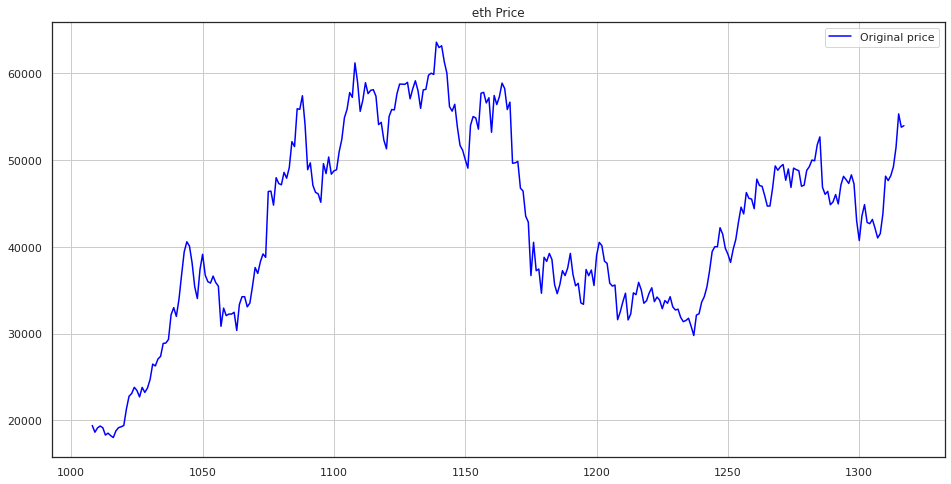

In [ ]:

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('white')
ax.plot(dataset["close"], color='blue', label='Original price')

plt.title(' eth Price ')
plt.grid()
plt.legend()

In [ ]:
# checking for nulls
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 1008 to 1317
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            310 non-null    object 
 1   close           310 non-null    float64
 2   MACD            310 non-null    float64
 3   Day_dif         310 non-null    float64
 4   Close_off_high  310 non-null    float64
 5   Volatility      310 non-null    float64
 6   TrendGoogle     310 non-null    float64
 7   open_tesla      310 non-null    float64
 8   fng_value       310 non-null    float64
dtypes: float64(8), object(1)
memory usage: 21.9+ KB


In [ ]:
# checking the main parameters
dataset.describe()

,close,MACD,Day_dif,Close_off_high,Volatility,TrendGoogle,open_tesla,fng_value
count,310.000,310.000,310.000,310.000,310.000,310.000,310.000,310.000
mean,42611.522,670.047,0.004,-0.127,0.072,32.011,74.671,59.190
std,10855.745,2133.127,0.044,0.562,0.041,24.446,58.441,26.719
min,18036.530,-5073.279,-0.144,-0.993,0.018,0.000,8.464,10.000
25%,34617.675,-856.217,-0.021,-0.623,0.045,19.000,17.717,28.000
50%,43088.260,978.768,0.003,-0.127,0.060,22.000,72.457,70.000
75%,50035.665,2118.619,0.028,0.323,0.087,44.068,112.985,78.000
max,63575.000,5248.182,0.195,0.999,0.317,160.000,301.828,95.000


In [ ]:
# use close only and fill NaN with ffil
df = dataset.set_index('date')[features]#.tail(n_past_total)
df = df.set_index(pd.to_datetime(df.index))
df.fillna(method='ffill',inplace=True)


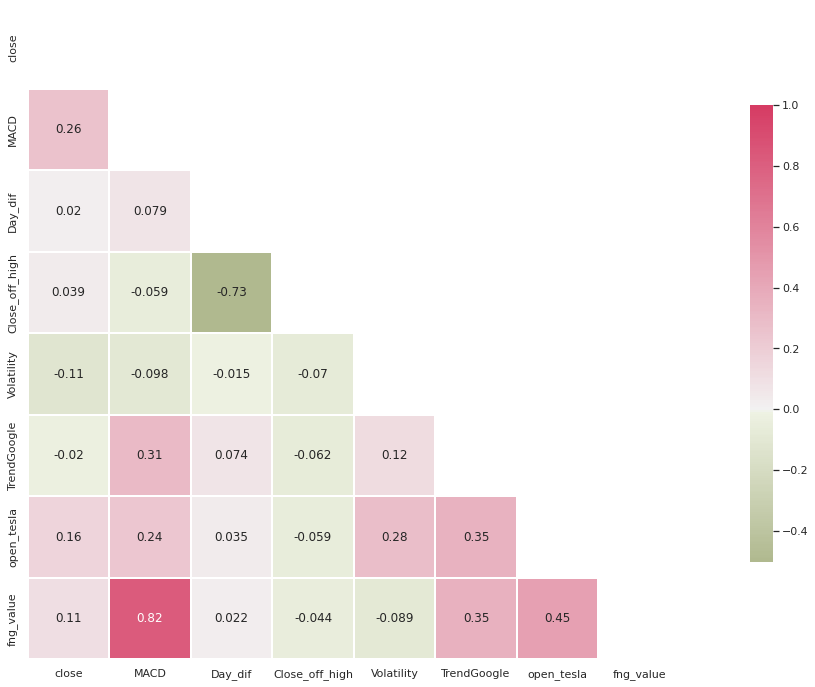

In [ ]:
# looking at the correlation of the main possible variables
import matplotlib.pyplot as plt
import seaborn as sns



sns.set_theme(style="white")




# Compute the correlation matrix
corr = dataset.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(98, 2, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,vmin=-0.5, vmax=1, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .7},annot=True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 1008 to 1317
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            310 non-null    object 
 1   close           310 non-null    float64
 2   MACD            310 non-null    float64
 3   Day_dif         310 non-null    float64
 4   Close_off_high  310 non-null    float64
 5   Volatility      310 non-null    float64
 6   TrendGoogle     310 non-null    float64
 7   open_tesla      310 non-null    float64
 8   fng_value       310 non-null    float64
dtypes: float64(8), object(1)
memory usage: 21.9+ KB



# Preprocessing the data

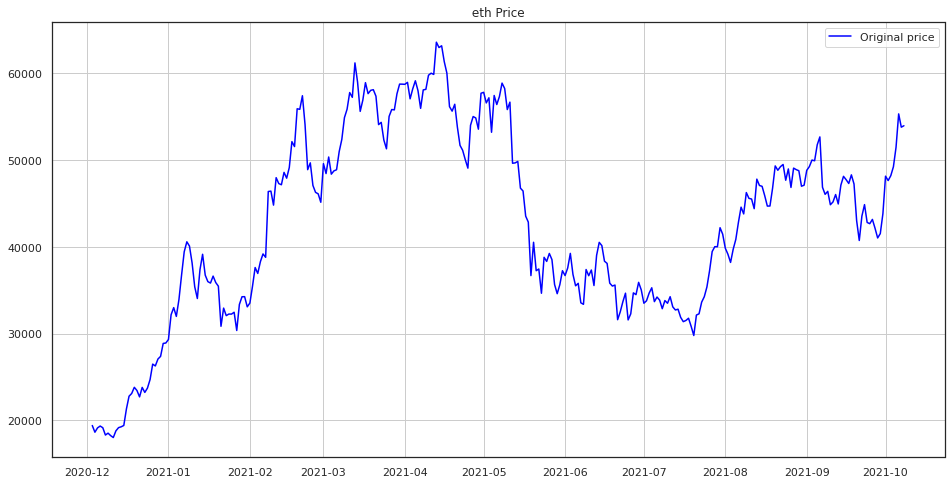

In [ ]:
# droppping firsts observations becuase they may not be representative of BTC behaviour now due to beginnings of crypto market
df = df.tail(n_past_total)
fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('white')
ax.plot(df["close"], color='blue', label='Original price')

plt.title(' eth Price ')
plt.grid()
plt.legend()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 310 entries, 2020-12-03 to 2021-10-08
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   close           310 non-null    float64
 1   Day_dif         310 non-null    float64
 2   Close_off_high  310 non-null    float64
 3   Volatility      310 non-null    float64
 4   TrendGoogle     310 non-null    float64
 5   open_tesla      310 non-null    float64
 6   fng_value       310 non-null    float64
dtypes: float64(7)
memory usage: 19.4 KB


In [ ]:
# train test split
training_set = df
training_set = training_set.values
print('training_set.shape:\t', training_set.shape)

training_set.shape:	 (310, 7)


In [ ]:
# scale
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled.shape: ', training_set_scaled.shape)
training_set_scaled

training_set_scaled.shape:  (310, 7)


array([[0.03042197, 0.45735064, 0.23852658, ..., 0.11022727, 0.46810416,
        0.96470588],
       [0.01348289, 0.30671862, 0.9116024 , ..., 0.06420455, 0.13615158,
        0.96470588],
       [0.02439981, 0.50250893, 0.04011514, ..., 0.        , 0.13615158,
        0.97647059],
       ...,
       [0.8186149 , 0.64407286, 0.07796782, ..., 0.1875    , 0.04159783,
        0.68235294],
       [0.78502176, 0.34234985, 0.78291413, ..., 0.175     , 0.04159783,
        0.77647059],
       [0.78867164, 0.43301614, 0.86555034, ..., 0.11875   , 0.04159783,
        0.75294118]])

In [ ]:
# creating a data structure with timesteps and 1 output
X_train = []
y_train = []

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    X_train.append(training_set_scaled[i-n_past:i, :])
    y_train.append(training_set_scaled[i:i+n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

X_test = X_train[-1].reshape(1, n_past, n_features)
y_test  = y_train[-1]



In [ ]:
# reshaping (needed to fit RNN)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_train.shape



(251, 30, 7)

# BUILD LSTM

In [ ]:
# Building the RNN

# Initialising 
regressor = Sequential()

# Input layer
regressor.add(LSTM(units=n_past, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], n_features))) 

#regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], 1))) 

# Hidden layers
for _ in range(n_layers):
    regressor.add(Dropout(dropout))
    regressor.add(LSTM(units=n_neurons, return_sequences=True, activation=activation))

# Last hidden layer 
regressor.add(Dropout(dropout))
regressor.add(LSTM(units=n_neurons, return_sequences=False))

# output layer
regressor.add(Dense(units=n_future,))

# Compiling 
regressor.compile(optimizer=optimizer, loss='mse',metrics=[tf.keras.metrics.MeanSquaredError()],
)


# Model summary
regressor.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 30, 30)            4560      
                                                                 
 dropout_45 (Dropout)        (None, 30, 30)            0         
                                                                 
 lstm_49 (LSTM)              (None, 30, 64)            24320     
                                                                 
 dropout_46 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_50 (LSTM)              (None, 30, 64)            33024     
                                                                 
 dropout_47 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_51 (LSTM)              (None, 30, 64)           

In [ ]:
#  Adding early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

In [ ]:
# Fitting the RNN to the Training set
res = regressor.fit(X_train, y_train
                    , batch_size=batch_size
                    , epochs=10
                    , validation_split=0.1
                    , callbacks=[early_stop]
                   )



Epoch 1/10
225/225 [==============================] - 45s 138ms/step - loss: 0.0638 - mean_squared_error: 0.0638 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2/10
225/225 [==============================] - 29s 127ms/step - loss: 0.0475 - mean_squared_error: 0.0475 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 3/10
225/225 [==============================] - 29s 130ms/step - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0184 - val_mean_squared_error: 0.0184
Epoch 4/10
225/225 [==============================] - 29s 131ms/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 5/10
225/225 [==============================] - 30s 134ms/step - loss: 0.0470 - mean_squared_error: 0.0470 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 6/10
225/225 [==============================] - 30s 132ms/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 7/10

In [ ]:
# Exporting the regressor
last_date = dataset.date.values[-1]
params = ['reg', last_date, n_past_total, n_past, n_future, activation, n_layers, n_neurons,batch_size ,n_features, patience, optimizer]
modelname = 'output/'
for i in params:
    modelname += str(i)
    if i!= params[-1]:
        modelname += '_'
if not os.path.exists(modelname):
    os.makedirs(modelname)
regressor.save('{}/regressor.h5'.format(modelname))

In [ ]:
list(res.history)

['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error']

In [ ]:
# Loads the weights
#regressor.load_weights(checkpoint_path)

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
# new_model = tf.keras.models.load_model('C:\Users\yonas\output\reg_2021-10-29_700_90_7_softsign_6_64_5_19_25_adam\regressor.h5')


# GridSearch


In [ ]:


#### Batch Size
batch_size1 = [ 1,7,14,30]


# Optimizer: Select!
#### Optimizer
optimizer1 = ['Adam', 'Adamax'] #'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'


#### Neuron Activation Function
activation1 = ['relu', 'softmax','softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'] #'softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'

#### Tune Dropout Regularization

dropout1 = [0.0, 0.1, 0.2, 0.3] #0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9

#### Tune the Number of Neurons in the Hidden Layer
n_neurons1 = [100, 200] #10, 50, 100, 200

n_past1=[10,20,30,40]
# number of hidden layers
n_layers1 = [3, 5,6]


In [ ]:
'''
# define the grid search parameters


scoring='mean_absolute_error'
param_grid = dict(dropout=dropout1, n_neurons=n_neurons1, n_layers=n_layers1, batch_size=batch_size1,n_past=n_past1)
grid = GridSearchCV(estimator=regressor, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
'''

'\n# define the grid search parameters\n\n\nscoring=\'mean_absolute_error\'\nparam_grid = dict(dropout=dropout1, n_neurons=n_neurons1, n_layers=n_layers1, batch_size=batch_size1,n_past=n_past1)\ngrid = GridSearchCV(estimator=regressor, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X_train, y_train)\n\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n'


# Validation

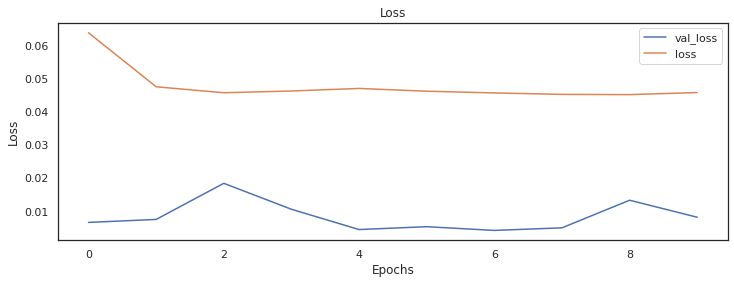

In [ ]:


# Plotting Loss/MSE

results = res

history = results.history
plt.figure(figsize=(12,4))
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('{}/Loss.png'.format(modelname))
plt.show()



In [ ]:


def dummy_invscaler(y, n_features):
    '''
    Since the scaler was trained into 2 features, it needs two features to perform the inverse scaleer.
    For that purpose, this function will create a dummy array and concatenate it to the y_pred/y_true.
    That dummy of ones will be drop after performing the inverse_transform.
    INPUTS: array 'y', shape (X,)
    '''
    y = np.array(y).reshape(-1,1)
    if n_features>1:
        dummy = np.ones((len(y), n_features-1))
        y = np.concatenate((y, dummy), axis=1)
        y = sc.inverse_transform(y)
        y = y[:,0]
    else:
        y = sc.inverse_transform(y)
    return y



y_pred:
 [43443.98194904328, 42365.27669454515, 41908.725277972815, 42700.498707657454, 42778.90138817072, 43245.48487353921, 44155.15682601333, 44186.186753090624, 43827.45615019381, 43911.15715275526, 44840.29609586954, 43945.13210002839, 43697.45454440594, 44058.86416567445, 44491.366845901015, 44508.74382220864, 44622.66588915765, 44776.54523011863, 45581.60246518433, 45653.265528051255, 45547.445659521225, 45773.26492239058, 46358.99551053941, 46531.09869075835, 46280.44625759244, 46707.64518716216, 46706.85532460272, 46751.31291519046, 46110.2159473598, 46644.79275614381]
y_true:
 [[46395.14], [44850.91], [45173.69], [46025.24], [44940.73], [47111.52], [48121.41], [47737.82], [47299.98], [48292.74], [47241.75], [43015.62], [40734.38], [43543.61], [44865.26], [42810.57], [42670.64], [43160.9], [42147.35], [41026.54], [41524.28], [43824.1], [48141.61], [47634.9], [48200.01], [49224.94], [51471.99], [55315.0], [53785.22], [53951.43]]


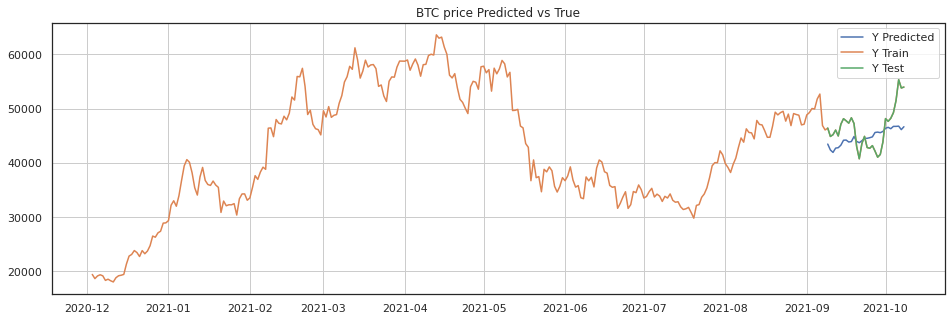

In [ ]:


# Validation

# getting the predictions
y_pred = regressor.predict(X_test).tolist()[0]
y_pred = dummy_invscaler(y_pred, n_features)

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=df[['close']].tail(n_future).index, 
                         columns=df[['close']].columns)

# getting the true values
y_true_df = df[['close']]#.tail(n_future)
y_true = y_true_df.tail(n_future).values

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())


# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred_df, label='Y Predicted')
plt.plot(y_true_df, label='Y Train')
plt.plot(y_true_df.tail(n_past), label='Y Test')

plt.title('BTC price Predicted vs True')
plt.legend()
plt.savefig('{}/Validation.png'.format(modelname))
plt.grid()
plt.show()



In [ ]:
listetrue = y_true.tolist()
listepred = y_pred.tolist()

In [ ]:
listetrue = np.array(listetrue).reshape(30,1)
listepred = np.array(listepred).reshape(30,1)
print('true',str(np.shape(listetrue)))
print('pred',str(np.shape(listepred)))

true (30, 1)
pred (30, 1)


In [ ]:

# Root Mean Square Error (RMSE)
rmse = math.sqrt(mean_squared_error(listepred, listetrue))
moy = y_true.mean()
Nrmse = rmse/moy
Nrmse


0.08044114209036655

In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


Mape= mape(listepred, listetrue)
Mape


7.085178871082311

In [ ]:


#Explained variance regression score function.
explained_variance_score(y_true, y_pred)
# Best possible score is 1.0, lower values are worse.



0.18679590963693882


# Predictions

y_pred:
 [42591.34755707979, 42757.104068039356, 42594.306721650064, 43695.850950343905, 44278.17003451586, 43621.81343814731, 44847.674798345564, 44798.709132683274, 45367.45371643454, 44745.99391654134, 45780.829574483636, 45492.734413945676, 45233.02870703935, 45925.63632797003, 46912.43867356479, 45824.84349759519, 46076.13184628189, 46628.41626589745, 46976.203182661535, 45767.15841540396, 45356.392341147366, 45146.39133590013, 45426.28057903498, 45009.03031973839, 45836.91072705239, 44672.10642663836, 45290.41374464333, 45538.934232355656, 45889.80113701373, 45432.641927029195]
y_true:
 [[46395.14], [44850.91], [45173.69], [46025.24], [44940.73], [47111.52], [48121.41], [47737.82], [47299.98], [48292.74], [47241.75], [43015.62], [40734.38], [43543.61], [44865.26], [42810.57], [42670.64], [43160.9], [42147.35], [41026.54], [41524.28], [43824.1], [48141.61], [47634.9], [48200.01], [49224.94], [51471.99], [55315.0], [53785.22], [53951.43]]


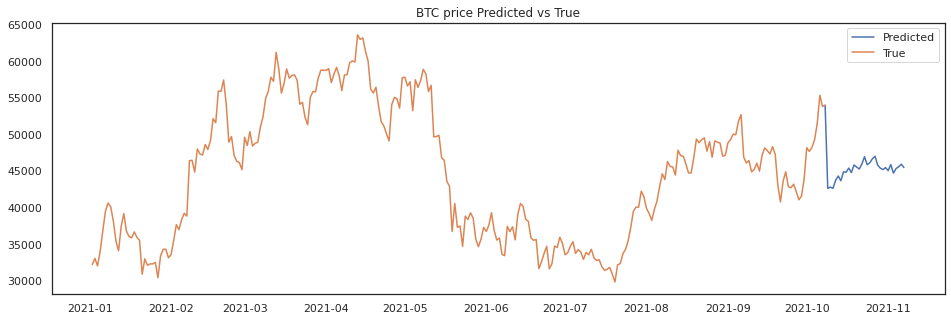

In [ ]:
# Predicting/Forecasting

# getting the predictions
x = df[features][-n_past:].values
x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, n_features)).tolist()[0]
y_pred = dummy_invscaler(y_pred, n_features)

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=pd.date_range(start=df[['close']].index[-1]+datetime.timedelta(days=1),
                                             periods=len(y_pred), 
                                             freq="D"), 
                         columns=df[['close']].columns)

# getting the true values
y_true_df = df[['close']]#tail(n_past)

# linking them
#y_true_df = y_true_df.append(y_pred_df.head(1))
y_pred_df = y_pred_df.append(y_true_df.tail(1)).sort_index()

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred_df, label='Predicted')
plt.plot(y_true_df, label='True')

plt.title('BTC price Predicted vs True')
plt.legend()
plt.savefig('{}/Predictions.png'.format(modelname))
plt.show()

In [ ]:
# export to csv
#y_pred_df.to_csv('{}/preds_{}.csv'.format(modelname,n_future))
# show
y_pred_df

,close
2021-10-08,53951.430
2021-10-09,42591.348
2021-10-10,42757.104
2021-10-11,42594.307
2021-10-12,43695.851
2021-10-13,44278.170
2021-10-14,43621.813
2021-10-15,44847.675
2021-10-16,44798.709
2021-10-17,45367.454


# cross validation

In [ ]:
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from keras.models import Sequential
from keras.layers import Activation, Dense,Flatten,LSTM,Dropout

In [ ]:
y_pred60scores = regressor.evaluate(X_test, df[['close']].tail(n_future), verbose=0)

ValueError: ignored

In [ ]:
cvscores = []
for train, test in kfold.split(x,y):
  print("%s: %.2f%%" % (regressor.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)

  
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

# SHAP

https://medium.datadriveninvestor.com/time-step-wise-feature-importance-in-deep-learning-using-shap-e1c46a655455

In [ ]:
pip install shap

     |████████████████████████████████| 564 kB 5.3 MB/s 


In [ ]:
import shap

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import load_model
import shap

In [ ]:
e = shap.DeepExplainer((regressor.layers[0].input, regressor.layers[-1].output),X_train)
test1 = X_test
shap_val = e.shap_values(X_test)
shap_val = np.array(shap_val)
shap_val = np.reshape(shap_val,(int(shap_val.shape[1]),int(shap_val.shape[2]),int(shap_val.shape[3])))
shap_abs = np.absolute(shap_val)
sum_0 = np.sum(shap_abs,axis=0)
f_names = features
x_pos = [i for i, _ in enumerate(f_names)]
plt1 = plt.subplot(311)
plt1.barh(x_pos,sum_0[1])
plt1.set_yticks(x_pos)
plt1.set_yticklabels(f_names)
plt1.set_title("Yesterday’s features (time-step 2)")
plt2 = plt.subplot(312,sharex=plt1)
plt2.barh(x_pos,sum_0[0])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title(" day before yesterday’s features(time-step 1)")
plt.tight_layout()
plt.show()

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: ignored